In [34]:
import pandas as pd
from sklearn.mixture import GaussianMixture

- Data Inspection: First, we'll load the data and inspect its structure.

- Histogram Visualization: We'll visualize the histogram to confirm the presence of the two peaks.

- Gaussian Mixture Model (GMM) Application: We'll apply a Gaussian Mixture Model to the data to estimate the parameters of the two distributions

- Determine Classification Boundary: Using the parameters from the GMM, we'll find the point where the two distributions intersect, which will serve as our classification boundary.

- Threshold Determination: We'll identify the threshold value based on the classification boundary.

In [1]:
# Load the data
data = pd.read_csv( r'/home/jovyan/data/SAR_drift_output/hpm_class.csv')

# Display the first few rows of the data
data.head()

,hpm
0,3.202490
1,4.794328
2,6.273803
3,3.840716
4,2.770370


In [32]:
# It is possible to import data from the notebook SAR1-SAR2_drift.ipynb instead of from csv
%store -r hpm_class

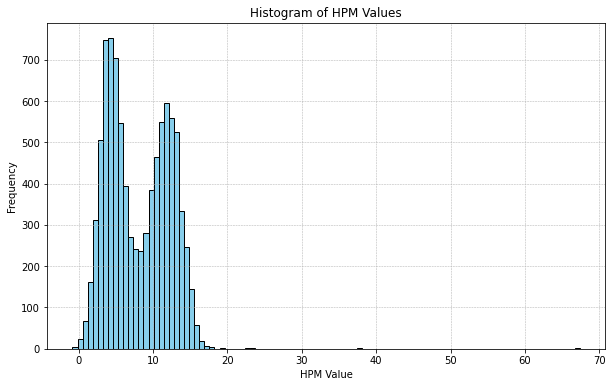

In [33]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(data['hpm'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('HPM Value')
plt.ylabel('Frequency')
plt.title('Histogram of HPM Values')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


The histogram  suggests that there are two distinct peaks, which is consistent with the presence of two Gaussian distributions in the data.

Next, let's proceed with the application of the Gaussian Mixture Model (GMM) to estimate the parameters of these two distributions.

In [44]:
# Applying Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data)

# Extracting means and standard deviations for the two distributions
means = gmm.means_.flatten()
covariances = gmm.covariances_.flatten()

means, covariances


(array([ 4.35682662, 11.5107574 ]), array([2.44847331, 5.51465012]))

The Gaussian Mixture Model has provided us with the following estimated parameters for the two Gaussian distributions:

First Distribution:
- Mean: ≈ 4.36
- Variance: ≈ 2.45

Second Distribution:
- Mean: ≈11.51
- Variance: ≈5.51


Next, to determine the classification boundary (i.e., the point where the two Gaussian distributions intersect), we can equate the two Gaussian functions and solve for the value of $( x )$ (in this case, the hpm value). This will give us the threshold value.

The equation of a Gaussian distribution is given by:

$f(x) = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$

Where:
- $( \mu )$ is the mean
- $( \sigma)$ is the standard deviation


I use Binary Search method, its discription is below in Appendix A:

In [22]:
def find_intersection(mean1, variance1, mean2, variance2, precision=0.001):
    """Find intersection point of two Gaussian distributions using binary search."""
    # Define initial boundaries
    low, high = min(mean1, mean2) - 5, max(mean1, mean2) + 5
    
    while high - low > precision:
        mid = (low + high) / 2
        diff = gaussian(mid, mean1, variance1) - gaussian(mid, mean2, variance2)
        
        if diff > 0:
            # Intersection lies in the right half
            low = mid
        else:
            # Intersection lies in the left half
            high = mid
    
    return (low + high) / 2

intersection = find_intersection(means[0], covariances[0], means[1], covariances[1])
np.round(intersection, 1)


7.4

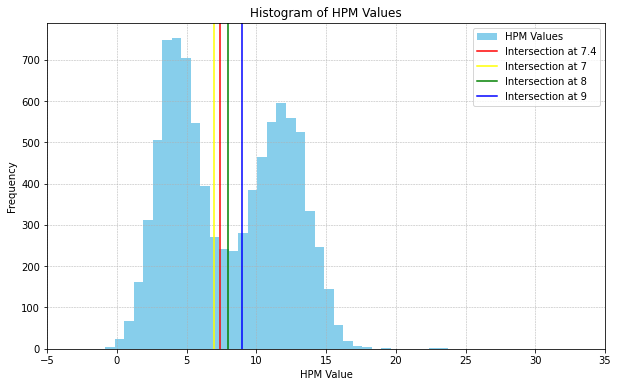

In [41]:
plt.figure(figsize=(10, 6))
plt.hist(data['hpm'], bins=100, color='skyblue',  label='HPM Values')
plt.xlabel('HPM Value')
plt.ylabel('Frequency')
plt.title('Histogram of HPM Values')
plt.axvline(intersection, color='red', label=f'Intersection at {np.round(intersection, 1)}')
plt.axvline(7, color='yellow', label=f'Intersection at 7')
plt.axvline(8, color='green', label=f'Intersection at 8')
plt.axvline(9, color='blue', label=f'Intersection at 9') #the threshold that seems to work better
plt.xlim([-5, 35])  # Limiting the x-axis to hessian value of 30
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

### Appendix A

Binary Search Overview:
Binary search is a method used to find a specific value within a sorted dataset by dividing the dataset into two halves repeatedly until the desired value is found or the entire dataset has been searched.

Application to Find Intersection:
Here, we're using binary search to find the point where two Gaussian distributions intersect. We're not looking in a dataset but rather a range of potential values.

Steps:

Initial Boundaries:

We start by defining initial boundaries for our search: low and high.
We pick the smallest mean of the two distributions and subtract 5 to get low and pick the largest mean and add 5 to get high. This gives us a broad range to search within.
The choice of +/- 5 is somewhat arbitrary; it's a way to make sure our initial search range is likely to contain the intersection point. If the Gaussian distributions are widely separated, you might need a larger value than 5.
Iterative Search:

We calculate the midpoint of our current range: mid = (low + high) / 2.
We then evaluate the difference between the two Gaussian distributions at this midpoint.
If the difference is positive, it means the first Gaussian is higher than the second at this point, so the intersection must be to the right (larger values). Thus, we update low to be mid.
If the difference is negative or zero, it means the second Gaussian is higher, or they're nearly equal. The intersection is likely to the left (smaller values). So, we update high to be mid.
Stopping Criterion:

We keep narrowing our search range in this manner until the difference between high and low is smaller than a set precision (in this case, 0.001). This precision determines how accurate our intersection point will be.
Return Result:

Once the loop stops, we return the midpoint of the final narrowed-down range, which is our best estimate for the intersection point.